In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/cats vs dogs.zip'

In [ ]:
import shutil
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
from io import BytesIO
from ipywidgets import widgets

In [ ]:
original_dir = '/content/PetImages'
new_base_dir = '/content/Cats_vs_Dogs'
os.makedirs(new_base_dir, exist_ok=True)

In [ ]:
# Create train/test directories
train_dir = os.path.join(new_base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(new_base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Create class subdirectories
train_cats_dir = os.path.join(train_dir, 'cats')
os.makedirs(train_cats_dir, exist_ok=True)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.makedirs(train_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, 'cats')
os.makedirs(test_cats_dir, exist_ok=True)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.makedirs(test_dogs_dir, exist_ok=True)

In [ ]:
cat_images = [img for img in os.listdir('/content/PetImages/Cat') if img.lower().endswith(('.jpg', '.png'))]
dog_images = [img for img in os.listdir('/content/PetImages/Dog') if img.lower().endswith(('.jpg', '.png'))]

In [ ]:
print(len(cat_images))
print(len(dog_images))

12499
12499


In [ ]:
import tensorflow as tf
import os

def is_valid_image(file_path):
    try:
        img_data = tf.io.read_file(file_path)
        tf.io.decode_image(img_data)  # Checks if image is readable
        return True
    except:
        return False

# Filter out corrupt images from cat_images
cat_images = [img for img in cat_images
              if is_valid_image(os.path.join('/content/PetImages/Cat', img))]

# Filter out corrupt images from dog_images
dog_images = [img for img in dog_images
              if is_valid_image(os.path.join('/content/PetImages/Dog', img))]

print(f"Valid cat images: {len(cat_images)}")
print(f"Valid dog images: {len(dog_images)}")

Valid cat images: 12497
Valid dog images: 12494


In [ ]:
train_cats = random.sample(cat_images, 1000)
train_dogs = random.sample(dog_images, 1000)

remaining_cats = [img for img in cat_images if img not in train_cats]
remaining_dogs = [img for img in dog_images if img not in train_dogs]

test_cats = random.sample(remaining_cats, 500)
test_dogs = random.sample(remaining_dogs, 500)

In [ ]:
print(type(train_cats))
print(len(train_cats))
print(type(train_dogs))
print(len(train_dogs))
print(type(test_cats))
print(len(test_cats))
print(type(test_dogs))
print(len(test_dogs))

<class 'list'>
1000
<class 'list'>
1000
<class 'list'>
500
<class 'list'>
500


In [ ]:
def copy_images(file_list, src_dir, dest_dir):
    for img in file_list:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.copyfile(src_path, dest_path)



copy_images(train_cats, '/content/PetImages/Cat', train_cats_dir)
copy_images(train_dogs, '/content/PetImages/Dog', train_dogs_dir)

copy_images(test_cats, '/content/PetImages/Cat', test_cats_dir)
copy_images(test_dogs, '/content/PetImages/Dog', test_dogs_dir)

In [ ]:
# now our dataset is created successfully
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog images: {len(os.listdir(train_dogs_dir))}')

print(f'total validation cat images: {len(os.listdir(test_cats_dir))}')
print(f'total validation dog images: {len(os.listdir(test_dogs_dir))}')

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


In [ ]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")

5 files in cats subdir: ['12391.jpg', '8878.jpg', '9256.jpg', '8419.jpg', '5806.jpg']
5 files in dogs subdir: ['2354.jpg', '5301.jpg', '9245.jpg', '500.jpg', '5806.jpg']


In [ ]:
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )


# Optimize the datasets for training
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


**Data** **augmentation**

In [ ]:
FILL_MODE = 'nearest'

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(150, 150, 3)),
    tf.keras.layers.RandomFlip(0.2),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE)
])

In [ ]:
def create_model():
    '''Creates a CNN with 4 convolutional layers'''
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
def demo_augmentation(sample_image, model, num_aug):
    '''Takes a single image array, then uses a model to generate num_aug transformations'''

    # Instantiate preview list
    image_preview = []

    # Convert input image to a PIL image instance
    sample_image_pil = tf.keras.utils.array_to_img(sample_image)

    # Append the result to the list
    image_preview.append(sample_image_pil)

    # Apply the image augmentation and append the results to the list
    for i in range(NUM_AUG):
        sample_image_aug = model(tf.expand_dims(sample_image, axis=0))
        sample_image_aug_pil = tf.keras.utils.array_to_img(tf.squeeze(sample_image_aug))
        image_preview.append(sample_image_aug_pil)

    # Instantiate a subplot
    fig, axes = plt.subplots(1, NUM_AUG + 1, figsize=(12, 12))

    # Preview the images.
    for index, ax in enumerate(axes):
        ax.imshow(image_preview[index])
        ax.set_axis_off()

        if index == 0:
            ax.set_title('original')
        else:
            ax.set_title(f'augment {index}')

In [ ]:
# Get a batch of images
sample_batch = list(train_dataset.take(1))[0][0]
print(f'images per batch: {len(sample_batch)}')

images per batch: 20


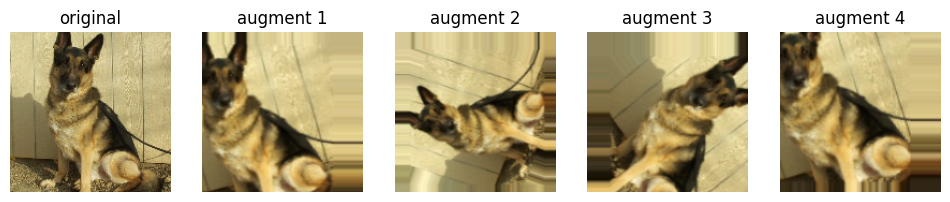

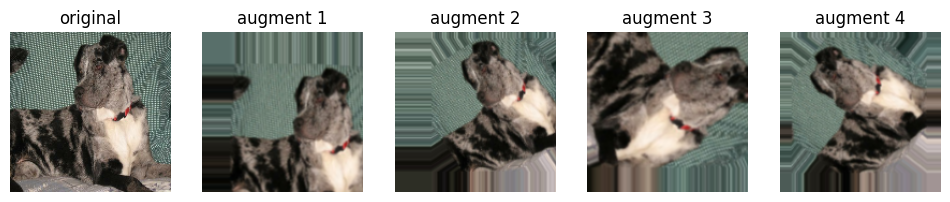

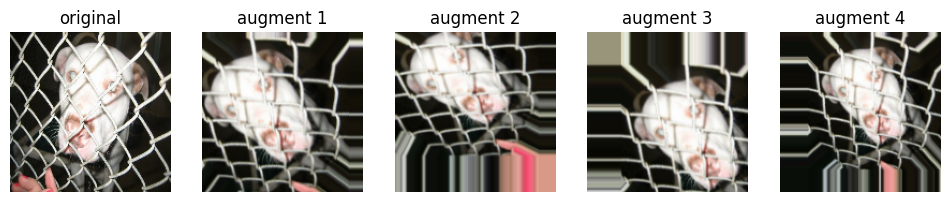

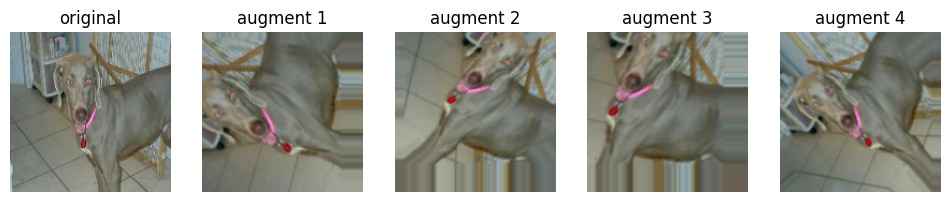

In [ ]:
NUM_AUG = 4

# Apply the transformations to the first 4 images
demo_augmentation(sample_batch[0], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[1], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[2], data_augmentation, NUM_AUG)
demo_augmentation(sample_batch[3], data_augmentation, NUM_AUG)

# Uncomment the line below to delete the variable to free up some memory
# del sample_batch

In [ ]:
# Instantiate the base model
model_without_aug = create_model()

# Prepend the data augmentation layers to the base model
model_with_aug = tf.keras.models.Sequential([
    data_augmentation,
    model_without_aug
])

# Compile the model
model_with_aug.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics=['accuracy'])

In [ ]:
EPOCHS=80

# Train the new model
history_with_aug = model_with_aug.fit(
      train_dataset_final,
      epochs=EPOCHS,
      validation_data=validation_dataset_final,
      verbose=2)

Epoch 1/80
100/100 - 10s - 95ms/step - accuracy: 0.5115 - loss: 0.6956 - val_accuracy: 0.5030 - val_loss: 0.6907
Epoch 2/80
100/100 - 2s - 23ms/step - accuracy: 0.5165 - loss: 0.6917 - val_accuracy: 0.5200 - val_loss: 0.6880
Epoch 3/80
100/100 - 2s - 18ms/step - accuracy: 0.5210 - loss: 0.6885 - val_accuracy: 0.5710 - val_loss: 0.6835
Epoch 4/80
100/100 - 2s - 18ms/step - accuracy: 0.5395 - loss: 0.6876 - val_accuracy: 0.6000 - val_loss: 0.6768
Epoch 5/80
100/100 - 3s - 25ms/step - accuracy: 0.5785 - loss: 0.6780 - val_accuracy: 0.5430 - val_loss: 0.6838
Epoch 6/80
100/100 - 2s - 18ms/step - accuracy: 0.5855 - loss: 0.6710 - val_accuracy: 0.5200 - val_loss: 0.7058
Epoch 7/80
100/100 - 3s - 26ms/step - accuracy: 0.5825 - loss: 0.6718 - val_accuracy: 0.5810 - val_loss: 0.6699
Epoch 8/80
100/100 - 2s - 20ms/step - accuracy: 0.6040 - loss: 0.6578 - val_accuracy: 0.6150 - val_loss: 0.6453
Epoch 9/80
100/100 - 2s - 23ms/step - accuracy: 0.6370 - loss: 0.6414 - val_accuracy: 0.6330 - val_loss

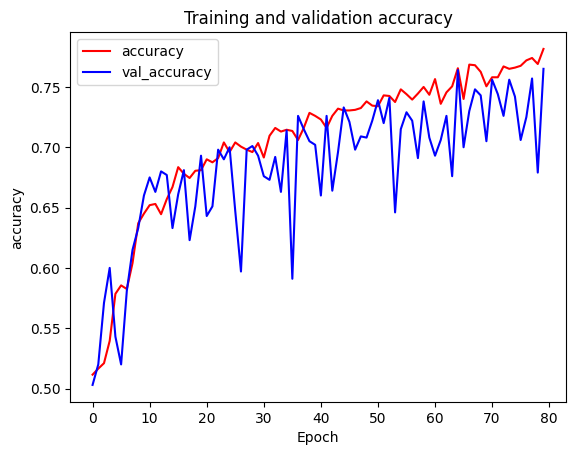

In [ ]:
# Plot the results of training with data augmentation
plt.plot(history_with_aug.history['accuracy'], label='accuracy', color='red')
plt.plot(history_with_aug.history['val_accuracy'], label = 'val_accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()